In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
plt.style.use('science')
from pypeit.utils import calc_ivar

import warnings
warnings.filterwarnings("ignore")

In [3]:
def ivarsmooth(flux, ivar, window):
    nflux = (flux.shape)[0]
    halfwindow = int(np.floor((np.round(window) - 1)/2))
    shiftarr = np.zeros((nflux, 2*halfwindow + 1))
    shiftivar = np.zeros((nflux, 2*halfwindow + 1))
    shiftindex = np.zeros((nflux, 2*halfwindow + 1))
    indexarr = np.arange(nflux)
    indnorm = np.outer(indexarr,(np.zeros(2 *halfwindow + 1) + 1))
    for i in np.arange(-halfwindow,halfwindow + 1,dtype=int):
        shiftarr[:,i+halfwindow] = np.roll(flux,i)
        shiftivar[:, i+halfwindow] = np.roll(ivar, i)
        shiftindex[:, i+halfwindow] = np.roll(indexarr, i)
    wh = (np.abs(shiftindex - indnorm) > (halfwindow+1))
    shiftivar[wh]=0.0
    outivar = np.sum(shiftivar,axis=1)
    nzero, = np.where(outivar > 0.0)
    zeroct=len(nzero)
    smoothflux = np.sum(shiftarr * shiftivar, axis=1)
    if(zeroct > 0):
        smoothflux[nzero] = smoothflux[nzero]/outivar[nzero]
    else:
        smoothflux = np.roll(flux, 2*halfwindow + 1)

    return (smoothflux, outivar)

In [4]:
def plot(name_list, fits_list, idx_list, ylim_list):
    num = len(fits_list)
    fig, axs = plt.subplots(num, 1, figsize=(10,3*num))
    if num == 1:
        axs = [axs]
    for idx, ax in enumerate(axs):
        hdul = fits.open(fits_list[idx])
        output = Table(hdul[idx_list[idx]].data)
        flux = np.array(output['OPT_FLAM'])
        flux_ivar = np.array(output['OPT_FLAM_IVAR'])
        flux_err = 1 / np.sqrt(flux_ivar)
        wave = np.array(output['OPT_WAVE'])
        flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 3)

        ax.plot(wave[wave>5000], flux_sm[wave>5000], label=name_list[idx], color="black", lw=1.5)
        ax.plot(wave[wave>5000], calc_ivar(flux_ivar_sm)[wave>5000], 
                lw=1, color="red", alpha=0.6)
        ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
        ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)
        # ax.set_title("J0847+0139, window=3", fontsize=20)
        ax.set_xlim(9800, 11200)
        ax.set_ylim(ylim_list[idx][0], ylim_list[idx][1])
        ax.legend(loc="upper right")
    fig.tight_layout()
    return fig, axs

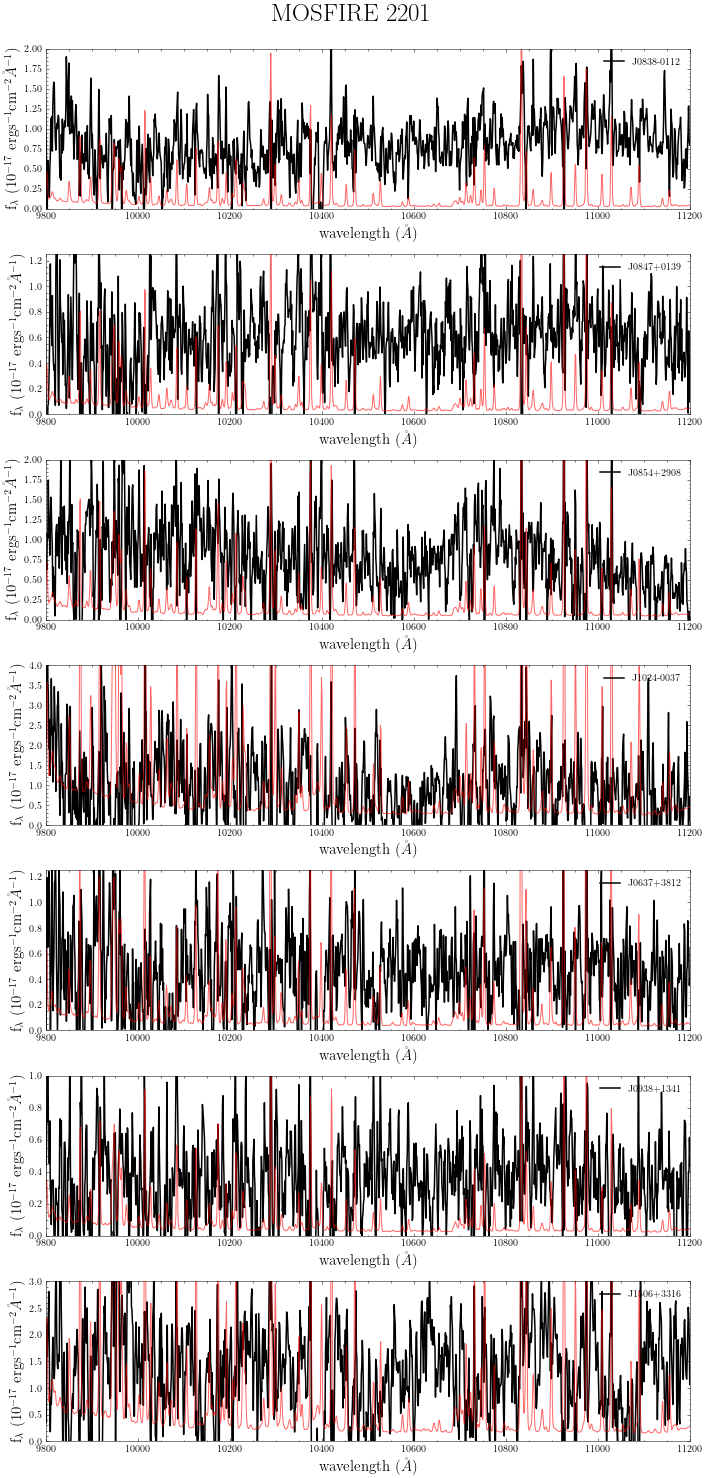

In [5]:
name_list = ["J0838-0112", "J0847+0139", "J0854+2908", "J1024-0037", "J0637+3812", "J0938+1341", "J1506+3316"]
fits_list = ["coadd2d/Science_coadd/spec1d_MF.20220111.39267-MF.20220111.40200-J0838.fits",
             "coadd2d/Science_coadd/spec1d_MF.20220111.42075-MF.20220111.42811-J0847+0139.fits",
             "coadd2d/Science_coadd/spec1d_MF.20220111.44674-MF.20220111.44492-J0854+2908.fits",
             "coadd2d/Science_coadd/spec1d_MF.20220111.50331-MF.20220111.50514-J1024.fits",
             "coadd2d/Science_coadd/spec1d_MF.20220111.33819-MF.20220111.34375-J0637+3812.fits",
            #  "coadd2d/Science_coadd/spec1d_MF.20220111.36463-MF.20220111.36647-J0730+5949.fits",
             "coadd2d/Science_coadd/spec1d_MF.20220111.46711-MF.20220111.48430-J0938+1341.fits",
             "coadd2d/Science_coadd/spec1d_MF.20220111.56605-MF.20220111.56422-J1506+3316.fits"]
idx_list = [4, 4, 7, 7, 5, 4, 4]
ylim_list = [(0,2), (0,1.25), (0,2), (-0.,4), (0,1.25), (0,1), (-0.,3)]
fig, axs = plot(name_list, fits_list, idx_list, ylim_list)

fig.suptitle("MOSFIRE 2201", fontsize=25)
fig.subplots_adjust(top=0.95)
plt.savefig("MOSFIRE_2201.pdf")